In [2]:
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage import measure

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
# split the image to H * W squares
def split_image(img, H, W):
    h, w = img.shape[:2]
    piece = max(h//H, w//W)
    new_h = piece * H
    new_w = piece * W
    if (new_h<h or new_w<w):
        piece += 1
        new_h = piece * H
        new_w = piece * W
    padding_image = np.zeros((new_h, new_w, 3), dtype=np.uint8)
    padding_image[:h, :w, :] = img
    left = (new_w - w) // 2
    top = (new_h - h) // 2
    rate = left*top
    
    piece_ = min(h//H, w//W)
    new_h_ = piece_ * H
    new_w_ = piece_ * W
    left_ = (w - new_w_) // 2
    top_ = (h - new_h_) // 2
    img = img[top_: top_ + new_h_, left_: left_ + new_w_]
    rate_ = left_*top_
    if (rate>rate_):
        print("no padding")
        return [img[i: i + piece_, j: j + piece_, :] for i in range(0, new_h_, piece_) for j in range(0, new_w_, piece_)]
    else:
        print("padding")
        return [padding_image[i: i + piece, j: j + piece, :] for i in range(0,new_h, piece) for j in range(0, new_w, piece)]

In [4]:
def count_distance(X, centroid):
    m, n = X.shape
    distances_sq = np.zeros(m)
    distances_sq  = np.sum((X - centroid)**2, axis=1)
    return distances_sq

In [5]:
# k-mean cluster
def k_mean_cluster(img, K = 3):
    image = Image.open(img)
    img_array = np.array(image)
    size = img_array.shape[0]*img_array.shape[1]
    flat_img = img_array.reshape(size, 3)

    # initialize the centroids
    centroids = np.zeros((K**3, 3))
    _ = 0
    for i in range(K):
        for j in range(K):
            for k in range(K):
                centroids[_, :] = [i*255//(K-1), j*255//(K-1), k*255//(K-1)]
                _ += 1
    n , _ = flat_img.shape
    k, _ = centroids.shape
    labels = np.zeros(n)
    labels[:] = -1
    for i in range(1000000):
        distances_sq = np.zeros((n, k))
        # assign the labels
        for j in range(k):
            distances_sq[:, j] = count_distance(flat_img, centroids[j, :])
        new_labels = np.argmin(distances_sq, axis=1)
        cost = np.sum(np.min(distances_sq, axis=1),axis=0).item()
        if ((labels == new_labels).all()):
            print("The number of iterations is", i)
            return labels, centroids, cost, k
        labels = new_labels
        count = np.bincount(labels)
        k = 0
        for j in range(len(count)):
            if (count[j] >= n//50000):
                mean = np.mean(flat_img[labels == j, :], axis=0)
                cluster_pixels = flat_img[labels == j, :]
                distances = count_distance(cluster_pixels, mean)
                nearest_index = np.argmin(distances)
                centroids[k, :] = cluster_pixels[nearest_index]
                k += 1
        centroids = centroids[:k, :]
    print("The number of iterations exceeds 1000000")
    return labels, centroids, cost, k


In [6]:
image_path = 'test.png'

In [7]:
labels, centroids, cost, k = k_mean_cluster(image_path, 4)
# print(centroids)
# print(np.bincount(labels))
# print(cost)
# print(k)

The number of iterations is 13


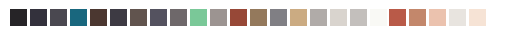

In [8]:
# display all the centroids in color in a same image
for i in range(k):
    img = np.zeros((100, 100, 3), dtype=np.uint8)
    img[:, :, :] = centroids[i, :]
    plt.subplot(1, k, i + 1)
    # hide the axis
    plt.axis('off')
    plt.imshow(img)   
plt.show()


In [9]:
count = np.bincount(labels)
count = count.astype(float)
total = np.sum(count)
weight = -np.log2(count/total)

In [10]:
# display the image with the centroids
image = Image.open(image_path)
image = np.array(image)
h, w = image.shape[:2]
new_image = np.zeros((h, w, 3), dtype=np.uint8)
for i in range(h):
    for j in range(w):
        new_image[i, j, :] = centroids[labels[i*w+j], :]
# plt.imshow(new_image)
# plt.show()
# save the image
new_image = Image.fromarray(new_image)
new_image.save('test_result.jpg')

no padding


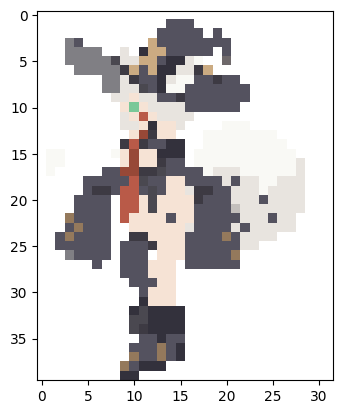

padding


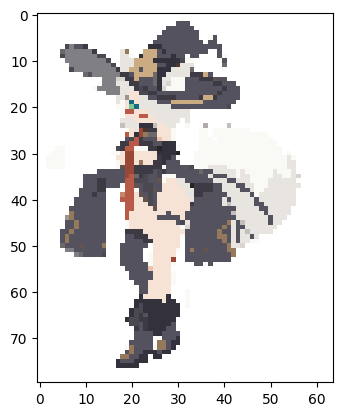

no padding


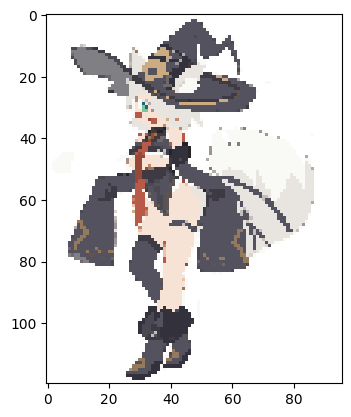

padding


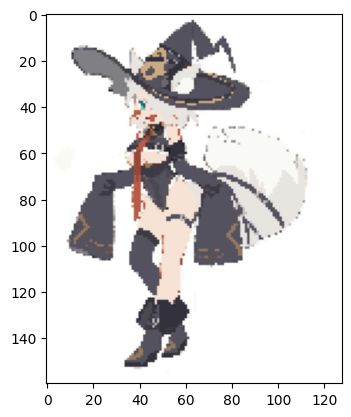

In [11]:
new_image = np.array(new_image)
original_h, original_w = new_image.shape[:2]
delt = np.ones((10, 10))
for i in range(1,10):
    for j in range(1,10):
        delt[i,j] = np.abs((original_w - ((original_h // i) * j)) * (original_h - ((original_w // i) * i))/(original_h*original_w))
pos = np.argmin(delt)
H_ = pos//10
W_ = pos%10
# H *= (32 if (pos) <= 88 else 16)
# W *= (32 if (pos) <= 88 else 16)
# splited_image = np.array(split_image(new_image, H, W))
scales = (8,16,24,32)
for scale in scales:
    H = H_ * scale
    W = W_ * scale
    splited_image = np.array(split_image(new_image, H, W))
    pix_image = np.zeros((H, W, 3), dtype=np.uint8)
    for i in range(H):
        for j in range(W):
            small = splited_image[i * W + j]
            small = small.reshape(-1, 3)
            result = np.zeros(k)
            for pix in range(small.shape[0]):
                try:
                    label = centroids.tolist().index(small[pix].tolist())
                    result[label] += weight[label]
                except:
                    label = len(weight) - 1
                    result[label] += weight[label]
            label = np.argmax(result)
            pix_image[i, j, :] = centroids[label, :]
    plt.imshow(pix_image)
    plt.show()
    # save the image
    pix_image = Image.fromarray(pix_image)
    pix_image.save('test_result_{}.png'.format(scale))


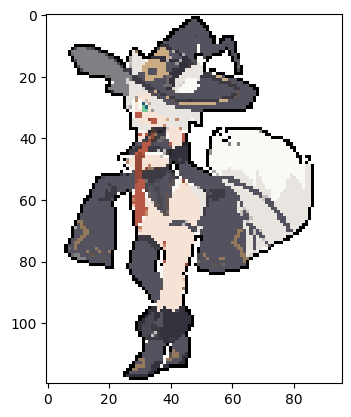

In [69]:
# Read image using cv2
image_path = 'test_result_24.png'
image_org = cv2.imread(image_path)
image = np.zeros_like(image_org)
background_color = np.argmin(weight)
# change all the background pixels to white and other pixels to black
image[np.where((image_org != centroids[background_color]).all(axis = 2))] = [255,255,255]
image[np.where((image_org == centroids[background_color]).all(axis = 2))] = [0,0,0]

# 标记连通区域
labels = measure.label(image, connectivity=2)

# 计算连通区域的面积
regions = measure.regionprops(labels)
areas = [region.area for region in regions]

# 设置面积阈值
threshold_area = np.max(areas)

# 删除面积小于阈值的连通块
for region in regions:
    if region.area < threshold_area:
        labels[labels == region.label] = 0

processed_image = labels > 0
# numpy bool to int
processed_image = processed_image.astype(int)*255
processed_image = processed_image.astype(np.uint8)
edges = cv2.Canny(processed_image, 0, 200)

original_image = cv2.imread(image_path)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
original_image[np.where((processed_image == 0).all(axis = 2))] = [255,255,255]
original_image[np.where(edges == 255)] = [0,0,0]

plt.imshow(original_image)

Image.fromarray(original_image).save('final.png')